<h1> ML Methods for Financial Product Prediction </h1>
<h3> <emph> Project by: System Breakers </emph> </h3>
<h4> Yumeng Du, Yi Gong, Allen (Yi Xin) Hu, Jielin (Katherine) Mao, Zhiyuan Ren </h4>

Having the suitable financial products is critical for consumer's financial well-being, as well as profit generation for banks around the world. In this project, we use a real-world dataset provided by Santander (Spanish bank) to predict whether or not an individual will likely open-up a new credit card account with the bank. 

The following notebook will be split into 2 main sections.

1. Data Processing
2. ML Prediction
3. Results and Discussion

In [1]:
%matplotlib inline
#data importing related packages
import zipfile
import pandas as pd
import numpy as np

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

#data processing ml packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#ml packages
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

#model evaluation packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score

<h2> Data/Feature Processing </h2>

The main challenges of this part of our project is 3 fold:
1. Unbalanced response variable (25:1 unbalance ratio)
2. Primarily binary explainatory variables (do not have enough continuity)
3. General issues with missing values 
4. Large sum of data, cannot be run cheaply on a local machine

To address these issues, we will conduct the following apprach:

1. To simultaniously deal with issue 1) and 4), we decide to downsample the data by randomly selecting the same amount of rows from the majority class to match the amount of rows in the minority class. We find that downsampling does not reduce the data efficiency as the inherent size of the data is very large
2. To deal with issue 2), we conduct PCA pre-analysis to reintroduce continuity into the data and significantly reduce the amount of binary columns that we have to deal with. This drastically increases our model's accuracy as well as decrease the cost of running the model itself
3. To deal with issue 3), we use a simple imputation method deal with missing values. While removing NA values would also be valid due to the large data size, the non-systematic presense of NA values will force us to cut down a surprising amount of our data, therefore we opted for imputation rather than removal.

In [2]:
#loading the data into the notebook
zf = zipfile.ZipFile('train0328.csv.zip')
df_train_raw = pd.read_csv(zf.open('train0328.csv'),low_memory=False)
zf = zipfile.ZipFile('test0428.csv.zip')
df_test_raw = pd.read_csv(zf.open('test0428.csv'),low_memory=False)

df_train_raw.set_index('cust_code',inplace=True)
df_test_raw.set_index('cust_code',inplace=True)

#Note: even taking 5% of our data,
# we are still able to get over 45,000 rows 
df_train = df_train_raw.sample(frac=0.05)
df_test = df_test_raw.sample(frac=0.05)

In [3]:
assert df_train.shape[1] == df_test.shape[1]

<h3> Downsampling the data </h3>

In this step, we define a function which allows us to balance out our response variable (or class/label variable) by downsampling our majority class to the same size as our minority class. This has no data size related issues as our dataset is large.

In [4]:
def downsampling(df,class_,keys=None):
    """
    returns a dataframe that is downsampled
    and with nas removed
    """
    
    class_1_df = df[df[class_]==1]
    class_0_df = df[df[class_]==0]
    
    #print(class_0_df[class_].isna().any())
    #print(class_1_df[class_].isna().any())
    
    n_class_1 = class_1_df.shape[0]
    n_class_0 = class_0_df.shape[0]
    n_samples = min(n_class_1,n_class_0)
        
    from sklearn.utils import resample
    if n_class_0 <= n_class_1:
        downsample = resample(class_1_df,
                                replace=False,
                                n_samples=n_class_0,
                                random_state=42)
        ret_df = pd.concat([class_0_df,downsample],keys=keys)
            
    else:
        downsample = resample(class_0_df,
                                replace=False,
                                n_samples=n_class_1,
                                random_state=42)
        ret_df = pd.concat([downsample,class_1_df],keys=keys)
        
    return ret_df.reset_index().drop(columns='level_0')

In [5]:
#downsampling the training set
df_train_ds = downsampling(df_train,'new_credit_card',['no_cc','cc']).set_index('cust_code')

#sanity check for inconsistencies in downsamplings
assert df_train_ds.shape[1] == df_test.shape[1]
assert set(df_train_ds.columns) - set(df_test.columns) == set()

Now we move on to creating our tuning （aka 'full_train') and validation (aka 'final_test) dataframes. 

In [6]:
dropping = ['new_credit_card','next_credit_card','fetch_date','Unnamed: 0','prov_code']
df_test_filtered = df_test[df_test.loc[:,'new_credit_card']<2]

full_train_Xs = df_train_ds.drop(columns=dropping)
full_train_y = df_train_ds.loc[:,'new_credit_card']

final_test_Xs = df_test_filtered.drop(columns=dropping)
final_test_y = df_test_filtered.loc[:,'new_credit_card']

#sanity check for dataframe reshaping
assert full_train_Xs.shape[1] == final_test_Xs.shape[1]
assert final_test_y.shape[0] == final_test_Xs.shape[0]
assert full_train_y.shape[0] == full_train_Xs.shape[0]

<h3> Imputation/OHE pipeline </h3>

In this step, we define a preprocessing pipeline to deal with missing values as well as one-hot encode our categorical variables. We find that once the one-hot encoding is conducted, our dataframe size explodes. This combined with a unhealthy amount of binary columns naturally lends itself to PCA, which follows this step.

In [7]:
obj_Xs = full_train_Xs.drop(columns=['age','cust_seniority','income']).columns.tolist()
num_Xs = ['age','cust_seniority','income']

categorical_pipe = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False,dtype='int'))
    ])

numeric_pipe = Pipeline(steps=[
        ('imputing mean', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ])

preprocessor = ColumnTransformer(transformers=[
        ('categorical',categorical_pipe,obj_Xs),
        ('numerical',numeric_pipe,num_Xs)
    ])

In [8]:
from sklearn.model_selection import train_test_split
train_Xs, test_Xs, train_y, test_y = train_test_split(full_train_Xs,
                                                      full_train_y,
                                                      test_size=0.4,
                                                      random_state=42,
                                                      stratify=full_train_y)

Please note that fit_transform and transform are completely different, as we only fit_transform our training data, but we must only transform or test and validation (final_test_Xs),

In [9]:
pp_train_Xs = preprocessor.fit_transform(train_Xs)

In [10]:
pp_test_Xs = preprocessor.transform(test_Xs)
pp_final_Xs = preprocessor.transform(final_test_Xs)

#sanity check for the number of columns for each dataframe
assert pp_test_Xs.shape[1] == pp_train_Xs.shape[1] == pp_final_Xs.shape[1]

Now that we are finished with our data processing, we will move on to reducing the parameters by using PCA

In [11]:
from sklearn.decomposition import PCA
pca = PCA(.95)

pp_train_Xs = pca.fit_transform(pp_train_Xs)
pp_test_Xs = pca.transform(pp_test_Xs)
pp_final_Xs = pca.transform(pp_final_Xs)

<h2> Data Processing Complete </h2>

<h4> Begin ML model creation: Logistic Reg Baseline </h4>

In [12]:
#defining helper functions 

def get_confusion_mtx(df):
    from sklearn.metrics import confusion_matrix
    y_actu = df.loc[:,'true values']
    y_pred = df.loc[:,'predicted values']
    
    return confusion_matrix(y_actu,y_pred)

def graph_preds(validation,prediction):
    y_valid_ser = pd.Series(validation.reshape(1,-1)[0]).rename('true values')
    compare_df = pd.DataFrame(pd.Series(prediction).rename('predicted values')).join(y_valid_ser)
    
    confusion_mtx = get_confusion_mtx(compare_df)
    confusion_mtx = np.around(confusion_mtx/compare_df.shape[0],4)*100
    
    
    #adding jitters to the dataframe
    rows = compare_df.shape[0]
    compare_df = compare_df.apply(lambda x: x+np.random.randn(rows)*0.05)
    
    
    compare_df.plot.scatter(x='predicted values',
                            y='true values',
                            s=0.2)
    
    plt.xlim((-0.5,1.5))
    plt.ylim((-0.5,1.5))
    plt.xticks(range(0,2))
    plt.yticks(range(0,2))
    
    plt.text(0-0.3,1.3,f'False Negatives: {round(confusion_mtx[1,0],2)}%')#pred,actual
    plt.text(0-0.3,0.3,f'True Negatives: {round(confusion_mtx[0,0],2)}%')
    plt.text(1-0.3,0.3,f'False Positives: {round(confusion_mtx[0,1],2)}%')
    plt.text(1-0.3,1.3,f'True Positives: {round(confusion_mtx[1,1],2)}%')
    
    #plt.plot([-2,2],[-2,2],c='red',ls='--')
    plt.plot([0.5,0.5],[-0.5,1.5],c='black')
    plt.plot([-0.5,1.5],[0.5,0.5],c='black')
    
    plt.title('Scatterplot Representation of Logistic Confusion Matrix') 
    
    #display(compare_df)

the model has 
	Score of: 0.9676779438083533
	MAE of: 0.03232205619164672
	Cross Validation Scores of:[1.0, 0.9803921568627451, 0.9803921568627451, 0.9803921568627451, 0.9411764705882353] in training


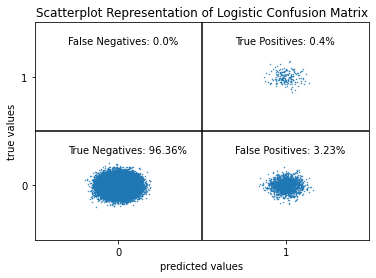

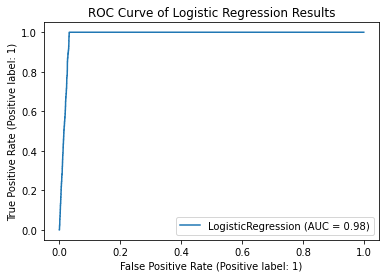

In [13]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')

logisticRegr.fit(pp_train_Xs, train_y)

from sklearn.metrics import mean_absolute_error

#preds_proba = logisticRegr.predict_proba(test_Xs)[:,0]
#print(preds_proba)
preds = logisticRegr.predict(pp_final_Xs)

mae = mean_absolute_error(final_test_y,preds)
score = logisticRegr.score(pp_final_Xs,final_test_y)
cv_scores = cross_val_score(logisticRegr, pp_train_Xs, train_y, cv=5)

print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}\n\tCross Validation Scores of:{list(cv_scores)} in training')

graph_preds(np.array(final_test_y),np.array(preds))
from sklearn import metrics
metrics.plot_roc_curve(logisticRegr, pp_final_Xs, final_test_y)
plt.title('ROC Curve of Logistic Regression Results')
plt.show()

However, notice that our model's precision is quite low. Therefore, we will have to try other models such as gradient boosted classifiers, which are effective according to this post (https://stats.stackexchange.com/questions/203088/high-recall-low-precision-for-unbalanced-dataset) standard Random Forest Classifiers etc.

<h3> Formatted/Cleaned Notebook stops here </h3>

In [16]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=42).fit(pp_train_Xs,train_y)

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, pp_train_Xs, train_y, cv=5)
scores

array([0.97409236, 0.8471371 , 0.89531245, 0.97792843, 0.77777218])

In [20]:
preds_lasso = reg.predict(pp_test_Xs)
preds_binary = np.where(preds_lasso>0.5,1,0)

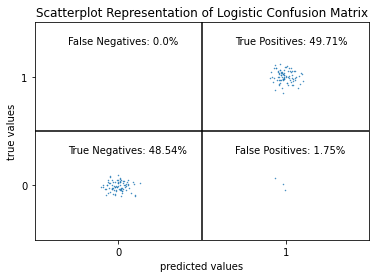

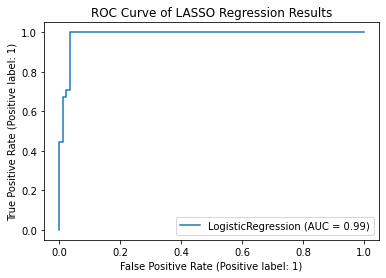

In [22]:
graph_preds(np.array(test_y),preds_binary)
from sklearn import metrics
metrics.plot_roc_curve(logisticRegr, pp_test_Xs, test_y)
plt.title('ROC Curve of LASSO Regression Results')
plt.show()

In [289]:

coef = reg.coef_.flatten()
coef_df = pd.DataFrame(zip(all_cols, coef), columns=["feature", "coef"])
coef_df["abs_coef"] = coef_df["coef"].apply(lambda x: abs(x))
coef_df["colors"] = coef_df["coef"].apply(lambda x: "green" if x > 0 else "red")
coef_df = coef_df.sort_values("abs_coef", ascending=False)

#graphing important features
    # Plot coef
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=coef_df.head(20),
           palette=coef_df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

SyntaxError: invalid syntax (458084992.py, line 1)

Computing regularization path using the lasso...


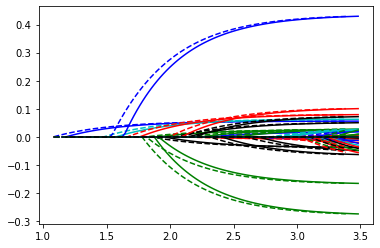

In [274]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(train_Xs, train_y, eps=eps)
alphas_enet, coefs_enet, _ = enet_path(train_Xs, train_y, eps=eps, l1_ratio=0.8)

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c)

    

In [ ]:
full_outcomes = raw_df.loc[:,'savings_account':'new_direct_debit']

In [ ]:
outcomes = raw_df.loc[:,'savings_account':'direct_debit']

In [ ]:
new_outcomes = raw_df.loc[:,'new_savings_account':'new_direct_debit']

In [ ]:
full_outcomes = full_outcomes.fillna(full_outcomes.mean())

In [ ]:
income_X = raw_df.loc[:,'income'].rename('income')

In [ ]:
Xs = raw_df.drop(columns='income')

In [ ]:
def get_heatmap(df):
    fig, ax = plt.subplots(figsize=(15,12))
    sns.heatmap(df.corr(),ax=ax)
    plt.show()

In [ ]:
get_heatmap(full_outcomes.corr()) # white bars come from singleton responses (ie everyone responded with 0 or 1)

From this preliminary analysis, we are able to see that 

1. current_account is negatively correlated with payroll and derivative_account.
2. There are certain "product mixes" in the pooled sample. Meaning that if an indiviudal has a pension account, it is likely that they will also have a home_account, loans, and morgage accounts.
3. having a payroll_account this period is associated with a higher chance of getting a new_home_account and new_credit_card.
4. there are autocorrelations between account openings. If there are more account A opened this month, there is a higher than random chance that more of the same type of account will also be opened in the next period
5. If people have a current credit card, there will be a higher than random chance that they will get a new credit card in the next period
6. credit_cards and tax accounts are positively correlated with new pension and payroll accounts. Potentially signaling that if individuals income changes, they would begin to purchase more financial products.

In [ ]:
credit_card = raw_df.credit_card

In [ ]:
cc_t = raw_df.groupby('fetch_date')['credit_card'].mean().rename('t')
cc_t1 = cc_t.shift(1)

In [ ]:
ser = cc_t - cc_t1

In [ ]:
ser.plot()

In [ ]:
cc_t1

In [ ]:
pd.DataFrame(cc_t).join(cc_t1)

In [ ]:
credit_card.shift(1)

In [ ]:
def get_uniques(df):
    for col in df:
        print(f'{col} has values: {df[col].value_counts()}')
        print(f'{col} has {df[col].isna().sum()} NAs')
        print('---000---000---')

### Can we use fiancial products to reversely explain income?

In [ ]:
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
def transform_y(y):
    return numeric_pipe.fit_transform(np.array(y).reshape(-1, 1))

In [ ]:
def split_col_types(Xs):
    #Xs.describe(include=object).T #13 object classes
    #obj_Xs = Xs.describe(include=object).T.index.tolist()
    obj_Xs = Xs.drop(columns=['age','cust_seniority']).columns.tolist()
    #num_Xs = X_train.select_dtypes(include='number').columns.tolist()
    num_Xs = ['age','cust_seniority']
    
    return num_Xs, obj_Xs

In [ ]:
def construct_lasso_estimator(alpha,processor):
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error

    lasso = Lasso(alpha=alpha)

    lasso_pipe = Pipeline(steps=[
        ('preprocess',processor),
        ('model',lasso)
    ])

In [ ]:
def score_model(X_train, X_valid, y_train, y_valid):
    
    print(X_train.columns)
    
    y_train_colvec = transform_y(y_train)
    y_valid_colvec = transform_y(y_valid)

    fitted_lasso = lasso_pipe.fit(X_train,y_train_colvec)
    preds = lasso_pipe.predict(X_valid)

    mae = mean_absolute_error(y_valid_colvec,preds)
    score = lasso_pipe.score(X_valid,y_valid_colvec)

    print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}')

In [ ]:
def run_model(frac=0.1,alpha=1e-3,graphing=True):
    
    #defining a subsample to run tests, 1 if include all
    n_df = raw_df.sample(frac=frac)
    
    #splitting the independent variables and the y variables
    Xs = n_df.drop(columns=['income','Unnamed: 0','cust_code'],axis=1)
    y = n_df.income

    #train-test split
    X_train, X_valid, y_train, y_valid = train_test_split(Xs, 
                                                          y, 
                                                          test_size=.3,
                                                          random_state=1029)
    
    obj_Xs = Xs.drop(columns=['age','cust_seniority']).columns.tolist()
    num_Xs = ['age','cust_seniority']

    numeric_pipe = Pipeline(steps=[
        ('imputing mean', SimpleImputer(strategy='mean')),
        ('scale', MinMaxScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore',sparse=False))
    ])

    processor = ColumnTransformer(transformers=[
        ('numerical',numeric_pipe,num_Xs),
        ('categorical',categorical_pipe,obj_Xs)
    ])
    
    #
    
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error

    lasso = Lasso(alpha=alpha)

    lasso_pipe = Pipeline(steps=[
        ('preprocess',processor),
        ('model',lasso)
    ])
    
    #
    
    y_train_colvec = transform_y(y_train)
    y_valid_colvec = transform_y(y_valid)

    fitted_lasso = lasso_pipe.fit(X_train,y_train_colvec)
    preds = lasso_pipe.predict(X_valid)

    mae = mean_absolute_error(y_valid_colvec,preds)
    score = lasso_pipe.score(X_valid,y_valid_colvec)

    print(f'the model has \n\tScore of: {score}\n\tMAE of: {mae}')
    
    print(num_Xs)
    print(obj_Xs)
    #construct_lasso_estimator(alpha, processor)
    #score_model(X_train, X_valid, y_train, y_valid)
    if graphing:
        graph_preds(y_valid_colvec,preds)
        get_top_features(lasso_pipe,obj_Xs,num_Xs)

In [ ]:
run_model(frac=0.5,alpha=1e-6)

In [ ]:
run_model(frac=0.5,alpha=1e-6)

1. Select a few important features (X), and plot it against (y)
2. Then look at the interaction between Xs (X_1, X_2)
3. Outliers, visualization, overfitting, feature selection, preprocessing steps

Prove that there is no temporal link

If classification -> 0.8
If regression -> depends lol

Train and test has to be classified 

In [ ]:
def get_top_features(lasso_pipe,obj_Xs,num_Xs):
    
    #get the categorical names
    cat_colnames = lasso_pipe.named_steps['preprocess'].transformers_[1][1]\
       .named_steps['one_hot'].get_feature_names(obj_Xs).tolist()
    
    #creating list of all features
    all_cols = np.concatenate([num_Xs,cat_colnames])
    
    #creating coefficient plot for important features
    coef = lasso_pipe.named_steps['model'].coef_.flatten()
    coef_df = pd.DataFrame(zip(all_cols, coef), columns=["feature", "coef"])
    coef_df["abs_coef"] = coef_df["coef"].apply(lambda x: abs(x))
    coef_df["colors"] = coef_df["coef"].apply(lambda x: "green" if x > 0 else "red")
    coef_df = coef_df.sort_values("abs_coef", ascending=False)
    
    #graphing important features
    # Plot coef
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x="feature",
                y="coef",
                data=coef_df.head(20),
               palette=coef_df.head(20)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title("Top 20 Features", fontsize=25)
    ax.set_ylabel("Coef", fontsize=22)
    ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
cat_colnames = lasso_pipe.named_steps['preprocess'].transformers_[1][1]\
   .named_steps['one_hot'].get_feature_names(obj_Xs).tolist()

In [ ]:
all_cols = np.concatenate([num_Xs,cat_colnames])

In [ ]:
len(all_cols)

In [ ]:
len(cat_colnames)

In [ ]:
coef = lasso_pipe.named_steps['model'].coef_.flatten()

In [ ]:
coef_df = pd.DataFrame(zip(all_cols, coef), columns=["feature", "coef"])

In [ ]:
coef_df["abs_coef"] = coef_df["coef"].apply(lambda x: abs(x))
coef_df["colors"] = coef_df["coef"].apply(lambda x: "green" if x > 0 else "red")
coef_df = coef_df.sort_values("abs_coef", ascending=False)

cust_code, prov_code, activity_index, segmentation needs to be converted to categorical

In [ ]:
num_Xs

In [ ]:
# Plot coef
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="coef",
            data=coef_df.head(20),
           palette=coef_df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
importance = np.abs(coef)
np.array(Xs.columns)[importance>0]

In [ ]:
np.count_nonzero(importance)

### Pipeline Building

### Construct Lasso Estimator

In [ ]:
graph_preds(y_valid_colvec,preds)